In [77]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [78]:
import pandas
import gensim

import matplotlib.pyplot as plt
import matplotlib

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

import xgboost as xgb

matplotlib.style.use('ggplot')

## 1. Read data

In [79]:
data_file = "../data/bdata.log.txt"

data = pandas.read_csv(data_file, sep = ',')

In [80]:
data.head()

,species,mhc,peptide_length,cv,sequence,inequality,meas
0,cow,BoLA-HD6,9,TBD,ALFYKDGKL,=,1.000000
1,cow,BoLA-HD6,9,TBD,ALYEKKLAL,=,1.000000
2,cow,BoLA-HD6,9,TBD,AMKDRFQPL,=,0.860543
3,cow,BoLA-HD6,9,TBD,AQRELFFTL,=,1.000000
4,cow,BoLA-HD6,9,TBD,FMKVKFEAL,=,0.957914


## 2. To one hot

In [81]:
selected_mhc = 'HLA-A*03:01'

indexes = data['mhc'][data['mhc'] == selected_mhc].index
indexes = data.iloc[indexes]['mhc'][data['peptide_length'] == 9].index
#indexes = data.index
selected_X = data['sequence'][indexes]
selected_y = data['meas'][indexes]

letters_X = selected_X.apply(list)

selected_X = pandas.DataFrame(list(letters_X))
selected_X = pandas.get_dummies(selected_X)

XX = selected_X[range(0, 20)].as_matrix() + selected_X[range(20, 40)].as_matrix() + selected_X[range(40, 60)].as_matrix() + selected_X[range(60, 80)].as_matrix() + selected_X[range(80, 100)].as_matrix() + selected_X[range(100, 120)].as_matrix() + selected_X[range(120, 140)].as_matrix() + selected_X[range(140, 160)].as_matrix() + selected_X[range(160, 180)].as_matrix()
selected_X[selected_X == 1] = 0.9
selected_X[selected_X == 0] = 0.05
selected_X = pandas.concat([selected_X, pandas.DataFrame(XX)], axis=1)

selected_X.shape

(5231, 200)

In [82]:
selected_y.to_csv("lol_pred.csv")

selected_X.shape

(5231, 200)

## 3. ml stuff

In [83]:
#normalize output
# m = selected_y.mean()
# d = selected_y.max() - selected_y.min()
# selected_y = (selected_y - m) / d

# train/test split
random_number = 52
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y,
                                                    test_size = 0.33, random_state = random_number)

In [84]:
def ridge_regression(X, y, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(X, y)
    y_pred = ridgereg.predict(X)
    
    #Return the result in pre-defined format
    rss = sum((y_pred - y)**2)
    return rss, ridgereg.intercept_, ridgereg

In [85]:
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2]

n = 6

rss = [0] * n
intercept = [0] * n
predictors = [0] * n

for i in range(n):
    rss[i], intercept[i], predictors[i] = ridge_regression(X_train, y_train, alpha_ridge[i])

In [86]:
# predict test data

test_rss = [0] * n
for i in range(n):
    m_pred = predictors[i]
    test_pred = m_pred.predict(X_test)
    test_rss[i] = mean((test_pred - y_test)**2)
    
    print '-' * 10
    print "alpha = ", alpha_ridge[i]
    print "train rss = ", rss[i]
    print "test rss = ", test_rss[i]
    
m_pred = predictors[5]
test_pred = m_pred.predict(X_test)

----------
alpha =  1e-15
train rss =  88.9680144288
test rss =  0.0282087413721
----------
alpha =  1e-10
train rss =  88.9680144288
test rss =  0.028208741372
----------
alpha =  1e-08
train rss =  88.9680144288
test rss =  0.0282087413653
----------
alpha =  0.0001
train rss =  88.9680151731
test rss =  0.0282086734226
----------
alpha =  0.001
train rss =  88.968088723
test rss =  0.0282080827483
----------
alpha =  0.01
train rss =  88.9753067544
test rss =  0.0282041989052


In [10]:
test_pred = pandas.DataFrame(test_pred)

In [11]:
y_test = pandas.DataFrame(y_test)

In [12]:
test_pred['1'] = np.array(y_test)

In [13]:
test_pred.corr()

,0,1
0,1.000000,0.757778
1,0.757778,1.000000


## NN

In [14]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

y_train = y_train.as_matrix().flatten()
y_test = y_test.as_matrix().flatten()

In [44]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(1))

model.compile(loss='mse', optimizer='rmsprop')

In [45]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=500, verbose=2, validation_split=0.15)

Train on 2978 samples, validate on 526 samples
Epoch 1/500
0s - loss: 0.0610 - val_loss: 0.0396
Epoch 2/500
0s - loss: 0.0363 - val_loss: 0.0319
Epoch 3/500
0s - loss: 0.0296 - val_loss: 0.0255
Epoch 4/500
0s - loss: 0.0249 - val_loss: 0.0249
Epoch 5/500
0s - loss: 0.0215 - val_loss: 0.0232
Epoch 6/500
0s - loss: 0.0194 - val_loss: 0.0226
Epoch 7/500
0s - loss: 0.0170 - val_loss: 0.0225
Epoch 8/500
0s - loss: 0.0149 - val_loss: 0.0347
Epoch 9/500
0s - loss: 0.0132 - val_loss: 0.0242
Epoch 10/500
0s - loss: 0.0129 - val_loss: 0.0218
Epoch 11/500
0s - loss: 0.0113 - val_loss: 0.0224
Epoch 12/500
0s - loss: 0.0109 - val_loss: 0.0223
Epoch 13/500
0s - loss: 0.0095 - val_loss: 0.0237
Epoch 14/500
0s - loss: 0.0093 - val_loss: 0.0227
Epoch 15/500
0s - loss: 0.0086 - val_loss: 0.0223
Epoch 16/500
0s - loss: 0.0082 - val_loss: 0.0217
Epoch 17/500
0s - loss: 0.0079 - val_loss: 0.0213
Epoch 18/500
0s - loss: 0.0070 - val_loss: 0.0222
Epoch 19/500
0s - loss: 0.0067 - val_loss: 0.0219
Epoch 20/500

In [46]:
preds = model.predict(X_test, verbose=0).flatten()

In [47]:
sum((preds - y_test)**2)

41.204960791650038

In [87]:
preds2 = preds.clip(min = 0)
preds2 = preds2.clip(max = 1)
mean((preds2 - y_test)**2)

0.023859077697726782

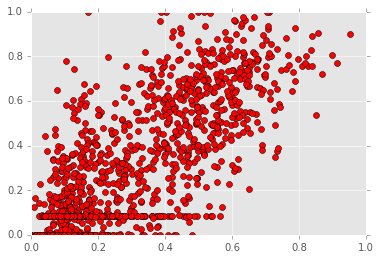

In [51]:
plt.plot(preds2, y_test, 'ro')

In [89]:
t = y_test > 0.2
n = preds2 > 0.2

sum(t == n) / float(y_test.shape[0])

0.84829183555298204

## XGBOOST TIME

In [ ]:
param = "objective" = "binary:logistic",
              "eval_metric" = "logloss",
              "eta" = 0.01, "max_depth" = 4, "subsample" = 0.9)

bst.cv = xgb.cv(param=param, data = train_heroes, label = y, 
                 nfold = cv.nfold, nrounds = cv.nround,
                 print.every.n = 1, early.stop.round = 25,
                 showsd = TRUE, prediction = TRUE)